# 统计方法与机器学习 Project2：基于Naive Bayes算法的文本分类（代码部分）


## 准备工作

In [76]:
import numpy as np
import re
import random
import pandas as pd

先导入一些基本的python库

In [77]:
from sklearn.datasets import fetch_20newsgroups # 也可以加载在本地
from sklearn.model_selection import train_test_split # 导入文本特征向量转化模块
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB # 导入朴素贝叶斯模型
from sklearn.metrics import classification_report # 模型评估模块

分别导入数据集，embedding模块，朴素贝叶斯和模型评估

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10.0, 8.0)

准备可视化工具

以下为手动实现的朴素贝叶斯方法供参考和算法原理解释，实际运用时为了方便得到评估精度和报告，依然是采取了sklearn库中的算法，所以如果单纯是想得到分类结果可以跳过以下部分

## 朴素贝叶斯算法（手动）

In [79]:
def createVocabList(dataSet):#所有词的词典
    vocabSet = set([])  
    for document in dataSet:
        vocabSet = vocabSet | set(document) 
        # 文本与词表的Union
    return list(vocabSet)

In [80]:
def setOfWords2Vec(vocabList, inputSet):
    #输入参数为词汇表和某个文档，输出文档向量，向量每个元素是1或0代表在词汇表中是否出现
    returnVec = [0]*len(vocabList)
    for word in inputSet:
        if word in vocabList:
            returnVec[vocabList.index(word)] = 1
        else: print("the word: %s is not in my Vocabulary!" % word)
    return returnVec

In [81]:
def bagOfWords2VecMN(vocabList, inputSet):
    # bagOfwords模型->vectorize
    returnVec = [0]*len(vocabList)
    for word in inputSet:
        if word in vocabList:
            returnVec[vocabList.index(word)] += 1
    return returnVec

In [82]:
def NaiveBayes_Train(trainMatrix, trainCategory):
    numTrainDocs = len(trainMatrix)
    numWords = len(trainMatrix[0])
    pAbusive = sum(trainCategory)/float(numTrainDocs)
    p0Num = np.ones(numWords); p1Num = np.ones(numWords)     
    p0Denom = 2.0; p1Denom = 2.0                   
    for i in range(numTrainDocs):
        if trainCategory[i] == 1:
            p1Num += trainMatrix[i]
            p1Denom += sum(trainMatrix[i])
        else:
            p0Num += trainMatrix[i]
            p0Denom += sum(trainMatrix[i])
    p1Vect = np.log(p1Num/p1Denom)          #change to np.log()
    p0Vect = np.log(p0Num/p0Denom)          
    return p0Vect, p1Vect, pAbusive

In [83]:
def NaiveBayes_Classify(vec2Classify, p0Vec, p1Vec, pClass1):
    p1 = sum(vec2Classify * p1Vec) + np.log(pClass1)   
    # 逐元素
    p0 = sum(vec2Classify * p0Vec) + np.log(1.0 - pClass1)
    if p1 > p0:
        return 1
    else:
        return 0

In [84]:
def textParse(bigString):    
    # 解析输入的文本
    listOfTokens = re.split(r'\W+', bigString)
    return [tok.lower() for tok in listOfTokens if len(tok) > 2]

In [13]:
news = fetch_20newsgroups(subset="all")

In [14]:
news.target

array([10,  3, 17, ...,  3,  1,  7])

## 调用朴素贝叶斯算法

In [15]:
x_train, x_test, y_train, y_test = train_test_split(news.data,news.target,test_size=0.25,random_state=3)

In [16]:
#3 贝叶斯分类器对新闻进行预测
# 进行文本转化为特征
vec = CountVectorizer()
x_train = vec.fit_transform(x_train)
x_test = vec.transform(x_test)
# 初始化朴素贝叶斯模型
mnb = MultinomialNB()
# 训练集合上进行训练， 估计参数
mnb.fit(x_train, y_train)
# 对测试集合进行预测 保存预测结果
y_predict = mnb.predict(x_test)
#模型评估
print("Accuracy:", mnb.score(x_test, y_test))
print("Indicators：\n",classification_report(y_test, y_predict, target_names=news.target_names))

Accuracy: 0.8554753820033956
Indicators：
                           precision    recall  f1-score   support

             alt.atheism       0.83      0.88      0.85       194
           comp.graphics       0.66      0.88      0.76       245
 comp.os.ms-windows.misc       0.84      0.16      0.27       253
comp.sys.ibm.pc.hardware       0.65      0.83      0.73       245
   comp.sys.mac.hardware       0.87      0.84      0.86       225
          comp.windows.x       0.72      0.90      0.80       255
            misc.forsale       0.94      0.75      0.84       258
               rec.autos       0.90      0.90      0.90       230
         rec.motorcycles       0.96      0.96      0.96       243
      rec.sport.baseball       0.97      0.95      0.96       242
        rec.sport.hockey       0.97      0.97      0.97       251
               sci.crypt       0.87      0.97      0.92       271
         sci.electronics       0.89      0.85      0.87       249
                 sci.med       0.

## 朴素贝叶斯算法的交叉验证

接下来实现交叉验证，获取最优的超参数lambda（拉普拉斯平滑因子），即使这是统计机器学习算法也比较耗时，所以现在的深度学习任务中一般不做Cross Validation

In [45]:
# 交叉验证
cross_validation_list= []
lambda_list = [0.0001,0.001,0.01,0.05,0.125,0.25,0.5,0.75,1,2] #构造超参数搜索空间
for hyper_param in lambda_list:
    temp_acc = 0
    temp_acc_list = []
    for fold in range(0,5):
        rand_state = random.randrange(0,100) #设置随机的随机状态
        x_train, x_test, y_train, y_test = train_test_split(news.data,news.target,test_size=0.2,random_state=rand_state)
        vec = CountVectorizer()
        x_train = vec.fit_transform(x_train)
        x_test = vec.transform(x_test)
        # 初始化朴素贝叶斯模型
        multinomial_naive_bayes = MultinomialNB(alpha=hyper_param)
        # 训练集合上进行训练， 估计参数
        multinomial_naive_bayes.fit(x_train, y_train)
        # 对测试集合进行预测 保存预测结果
        y_predict = multinomial_naive_bayes.predict(x_test)
        fold_accuracy = multinomial_naive_bayes.score(x_test, y_test)
        print("validation accuracy:", fold_accuracy ,"fold",fold+1,"lambda=",hyper_param)
        temp_acc+=fold_accuracy
        temp_acc_list.append(fold_accuracy)
    print("lambda:",hyper_param,"accuracy:",temp_acc/5)
    cross_validation_list.append(temp_acc_list)

validation accuracy: 0.8872679045092838 fold 1 lambda= 0.0001
validation accuracy: 0.8968169761273209 fold 2 lambda= 0.0001
validation accuracy: 0.8978779840848806 fold 3 lambda= 0.0001
validation accuracy: 0.8917771883289125 fold 4 lambda= 0.0001
validation accuracy: 0.9013262599469496 fold 5 lambda= 0.0001
lambda: 0.0001 accuracy: 0.8950132625994695
validation accuracy: 0.8970822281167109 fold 1 lambda= 0.001
validation accuracy: 0.8938992042440318 fold 2 lambda= 0.001
validation accuracy: 0.8909814323607427 fold 3 lambda= 0.001
validation accuracy: 0.8986737400530505 fold 4 lambda= 0.001
validation accuracy: 0.8856763925729443 fold 5 lambda= 0.001
lambda: 0.001 accuracy: 0.893262599469496
validation accuracy: 0.8809018567639257 fold 1 lambda= 0.01
validation accuracy: 0.9021220159151193 fold 2 lambda= 0.01
validation accuracy: 0.8896551724137931 fold 3 lambda= 0.01
validation accuracy: 0.8827586206896552 fold 4 lambda= 0.01
validation accuracy: 0.8827586206896552 fold 5 lambda= 0.01

## 交叉验证结果的可视化

**Remark：以下注释掉的内容纯粹是我为了导出数据到LaTeX，没有这个需求的话不需要下列被注释的步骤**

In [57]:
# round_cv_list = cross_validation_list 要注意np的数组赋值后，内存中的变量是共享的，会影响到后续步骤，先做可视化吧

In [58]:
# for k in round_cv_list:
#     for i in range(0,5):
#         k[i] = round(k[i],4)

In [59]:
# round_cv_list
# 上述的步骤只是为舍入到小数点后四位，把他们存到csv，方便我导入latex罢了，没有这个需求可以不做

[[0.892, 0.8976, 0.8894, 0.8971, 0.8944],
 [0.8944, 0.8987, 0.8966, 0.8814, 0.9011],
 [0.8881, 0.8979, 0.8923, 0.8748, 0.8926],
 [0.8836, 0.8782, 0.8825, 0.8918, 0.8798],
 [0.8878, 0.883, 0.8822, 0.8751, 0.8775],
 [0.8849, 0.8682, 0.8777, 0.8859, 0.8777],
 [0.8772, 0.8621, 0.8788, 0.8645, 0.8759],
 [0.8719, 0.8721, 0.8557, 0.8647, 0.866],
 [0.8456, 0.8605, 0.8615, 0.8525, 0.8493],
 [0.8146, 0.8194, 0.7992, 0.8016, 0.8212]]

In [60]:
# np.savetxt("cv_result.csv", round_cv_list, delimiter=',')

In [61]:
cv_mean=[] # 交叉验证得到的均值
for lst in cross_validation_list:
    cv_mean.append(np.mean(lst))

In [63]:
# np.savetxt("cv_mean.csv", cv_mean, delimiter=',') # 也是方便我导入latex罢了，没有这个需求可以不做

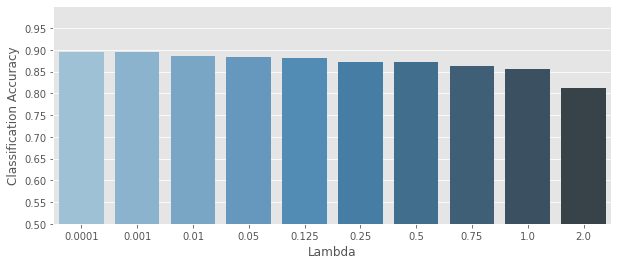

In [74]:
df = pd.DataFrame()
df['Lambda'] = lambda_list
df['Classification Accuracy'] =  cv_mean
plt.figure(figsize=(10, 4))
plt.ylim((0.5,1))
my_y_ticks = np.arange(0.5,1,0.05)
plt.yticks(my_y_ticks)
p1=sns.barplot( data=df, x='Lambda', y='Classification Accuracy',palette="Blues_d")
plt.show()
#我觉得seaborn制图的默认效果比matplotlib好看些

In [19]:
err_plot_data_dict = dict(zip(lambda_list,cross_validation_list)) # 制作字典，用于数据可视化

In [20]:
k_to_accuracies=err_plot_data_dict
k_choices = lambda_list

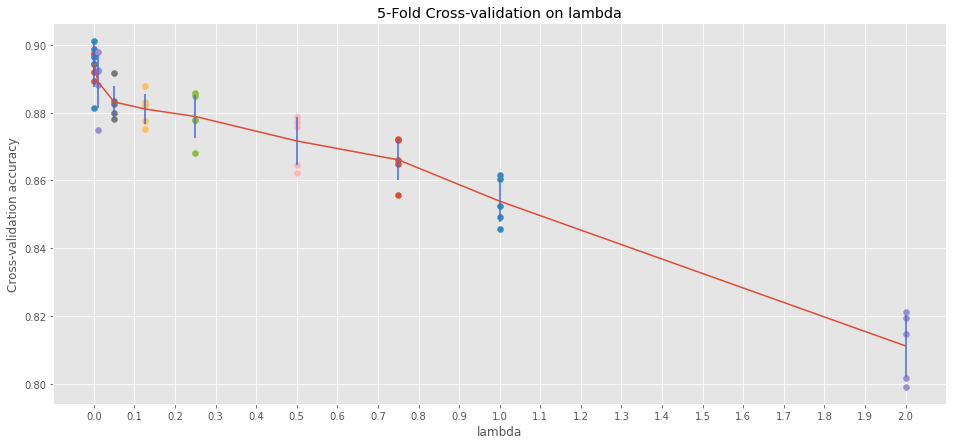

In [25]:
plt.rcParams['figure.figsize'] = (16.0, 7.0)
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)
plt.style.use('ggplot')
# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std,ecolor='royalblue')
my_x_ticks = np.arange(0,2.1,0.1)
plt.xticks(my_x_ticks)
plt.title('5-Fold Cross-validation on lambda')
plt.xlabel('lambda')
plt.ylabel('Cross-validation accuracy')
plt.show()

## 选取最优模型参数

In [93]:
x_train, x_test, y_train, y_test = train_test_split(news.data,news.target,test_size=0.15,random_state=1) # 切分训练集和测试集

In [94]:
#3 贝叶斯分类器对新闻进行预测
# 进行文本转化为特征
vec = CountVectorizer()
x_train = vec.fit_transform(x_train)
x_test = vec.transform(x_test)
# 初始化朴素贝叶斯模型
mnb = MultinomialNB(alpha=0.0001)
# 训练集合上进行训练， 估计参数
mnb.fit(x_train, y_train)
# 对测试集合进行预测 保存预测结果
y_predict = mnb.predict(x_test)
#模型评估
print("Accuracy:", mnb.score(x_test, y_test))
print("Indicators：\n",classification_report(y_test, y_predict, target_names=news.target_names))

Accuracy: 0.8878669968164131
Indicators：
                           precision    recall  f1-score   support

             alt.atheism       0.90      0.93      0.92       122
           comp.graphics       0.73      0.84      0.78       144
 comp.os.ms-windows.misc       0.95      0.48      0.64       152
comp.sys.ibm.pc.hardware       0.69      0.90      0.78       158
   comp.sys.mac.hardware       0.85      0.85      0.85       144
          comp.windows.x       0.85      0.86      0.85       146
            misc.forsale       0.86      0.75      0.80       146
               rec.autos       0.92      0.92      0.92       153
         rec.motorcycles       0.98      0.98      0.98       155
      rec.sport.baseball       0.98      0.96      0.97       148
        rec.sport.hockey       0.98      0.99      0.98       175
               sci.crypt       0.90      0.98      0.94       153
         sci.electronics       0.80      0.86      0.83       127
                 sci.med       0.

20分类问题准确率接近了0.9，这体现出了朴素贝叶斯模型的有效性。而对Laplacian Smoothing的分析中可见平化程度越小，文本分类准确率越高（越逼近理论最优值）。
